# Dimension reduction and manifold learning - Master MASH - Dauphine PSL
# Python Notebook Practice for Multidimensional Scaling (MDS)
### **Practice Overview:**

- **Objective**: Learn to apply Classical Multidimensional Scaling (MDS) using Python and visualize the results on different datasets.
- **Concepts Covered**:
  - Classical MDS.
  - Eigenvalue decomposition.
  - Eigenvalue decay plot.
  - Visualization of results on synthetic, non-Euclidean, and real datasets.
### **Key Takeaways:**
- Classical MDS finds a (low-dimensional) embedding from a dissimilarity matrix (treated as Euclidean), while preserving the pairwise dissimilarities as much as possible.
- The eigenvalue decay plot helps identify the optimal number of dimensions.

Load the necessary packages

In [1]:
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial import procrustes
from scipy.spatial.distance import pdist, squareform
from matplotlib import colormaps

from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

### Coding classical scaling (and its Landmark version)
Implement Classical Scaling from scratch.

In [2]:
def MDS_DIY(D, dim=2):
    # Step 1: Double centering of the distance matrix
    n = D.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H.dot(D**2).dot(H)
    
    # Step 2: Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    
    # Step 3: Sort eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Step 4: Select the top n_components eigenvectors and eigenvalues
    eigvals_top = eigvals[:dim]
    eigvecs_top = eigvecs[:, :dim]
    
    # Step 5: Project the points into the new space
    X_transformed = eigvecs_top * np.sqrt(eigvals_top)
    
    return X_transformed, eigvals

In [3]:
def landmark_MDS_DIY(D, lands, dim=2):
    # http://graphics.stanford.edu/courses/cs468-05-winter/Papers/Landmarks/Silva_landmarks5.pdf
    Dl = D[:,lands]
    n = len(Dl)

    # Centering matrix
    H = - np.ones((n, n))/n
    np.fill_diagonal(H,1-1/n)
    # YY^T
    H = -H.dot(Dl**2).dot(H)/2

    # Diagonalize
    evals, evecs = np.linalg.eigh(H)

    # Sort by eigenvalue in descending order
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]

    # Compute the coordinates using positive-eigenvalued components only
    w, = np.where(evals > 0)
    if dim:
        arr = evals
        w = arr.argsort()[-dim:][::-1]
        if np.any(evals[w]<0):
            print('Error: Not enough positive eigenvalues for the selected dim.')
            return []
    if w.size==0:
        print('Error: matrix is negative definite.')
        return []

    #Applying Classical MDS to the landmark distance matrix Dl
    V = evecs[:,w]
    L = V.dot(np.diag(np.sqrt(evals[w]))).T
    N = D.shape[1]
    Lh = V.dot(np.diag(1./np.sqrt(evals[w]))).T
    #Extrapolating to get trilateration of the rest
    Dm = D - np.tile(np.mean(Dl,axis=1),(N, 1)).T
    dim = w.size
    X = -Lh.dot(Dm)/2.
    X -= np.tile(np.mean(X,axis=1),(N, 1)).T

    _, evecs = sp.linalg.eigh(X.dot(X.T))

    return (evecs[:,::-1].T.dot(X)).T, evals

### Cumulated eigenvalues plot
To understand how many dimensions are required to capture most of the variance, write a function that allows to visualize how quickly the eigenvalues decay

In [4]:
def plot_eigenvalue_decay(eigenvalues):
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(eigenvalues), 'o-', color='blue')
    plt.title('Explained variance')
    plt.xlabel('Component Index')
    plt.ylabel('Cumulated eigenvalues')
    plt.grid(True)
    plt.show()

## Testing on 2D toy data
Apply Classical MDS on the following two-dimensional synthetic data

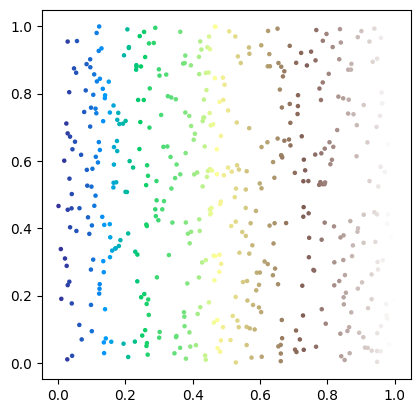

In [5]:
# generating a point set
n = 500
x = np.c_[np.sort(np.random.uniform(size=n)), np.random.uniform(size=n)]

terrain_cmap = colormaps.get_cmap('terrain') #get_cmap('terrain')
c = terrain_cmap(np.linspace(0, 1, n))  # Generate n colors

# plot the original points
plt.scatter(x[:, 0], x[:, 1], c=c, s=5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### First use (possibly noisy) Euclidean distances

First use sklearn's version **sklearn.manifold.MDS**

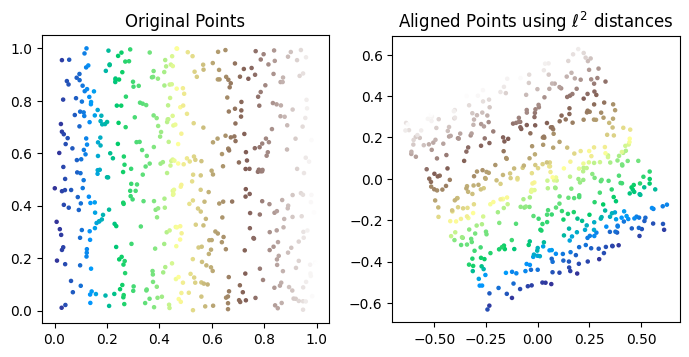

In [6]:
# noisy l2 (Euclidean) distances
d = pdist(x, metric='euclidean')
alpha = 0.5  # noise level
noise = np.random.uniform(1-alpha, 1+alpha, size=len(d))
d = d * noise
d_square = squareform(d)

mds = MDS(dissimilarity='precomputed',normalized_stress=False)
y = mds.fit_transform(d_square)
p
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Plot the first set of points on the first subplot
axes[0].scatter(x[:, 0], x[:, 1], c=c, s=5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title("Original Points")

# Plot the second set of points on the second subplot
axes[1].scatter(y[:, 0], y[:, 1], c=c, s=5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title("Aligned Points using $\ell^2$ distances")

# Display the plots side by side
plt.tight_layout()
plt.show()

Now use your handmade version

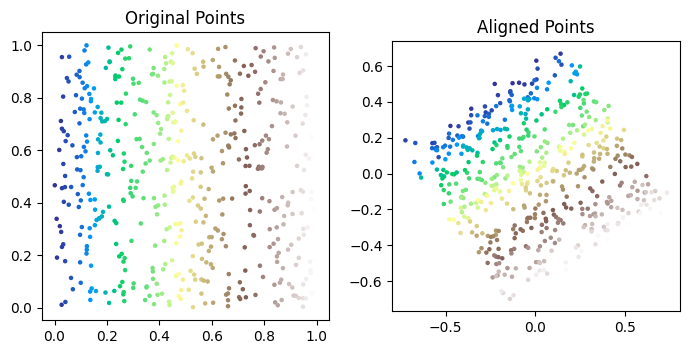

In [7]:
# noisy l2 (Euclidean) distances
d = pdist(x, metric='euclidean')
# noise level
alpha = 0.5
noise = np.random.uniform(1-alpha, 1+alpha, size=len(d))
d = d * noise
d_square = squareform(d)

y,evals = MDS_DIY(d_square,dim=2)

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Plot the first set of points on the first subplot
axes[0].scatter(x[:, 0], x[:, 1], c=c, s=5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title("Original Points")

# Plot the second set of points on the second subplot
axes[1].scatter(y[:, 0], y[:, 1], c=c, s=5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title("Aligned Points")

# Display the plots side by side
plt.tight_layout()
plt.show()

Plot the cumulated eigenvalues. What do you notice depending on the noise level on the distance matrix?

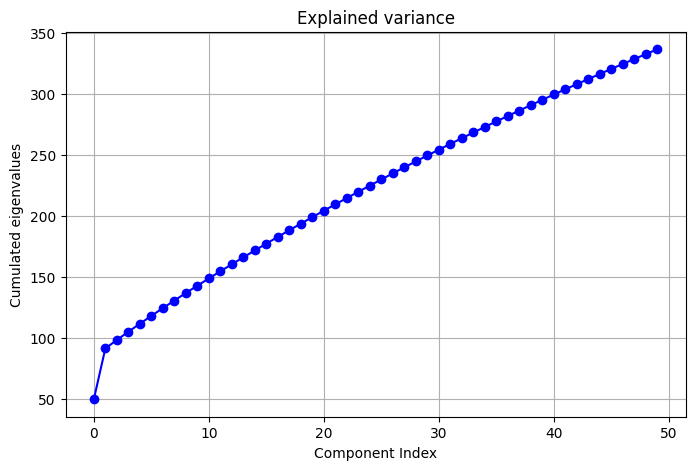

In [8]:
plot_eigenvalue_decay(evals[:50])

### Now use (possibly noisy) $\ell^1$ Manhattan distances

First use sklearn's version **sklearn.manifold.MDS**

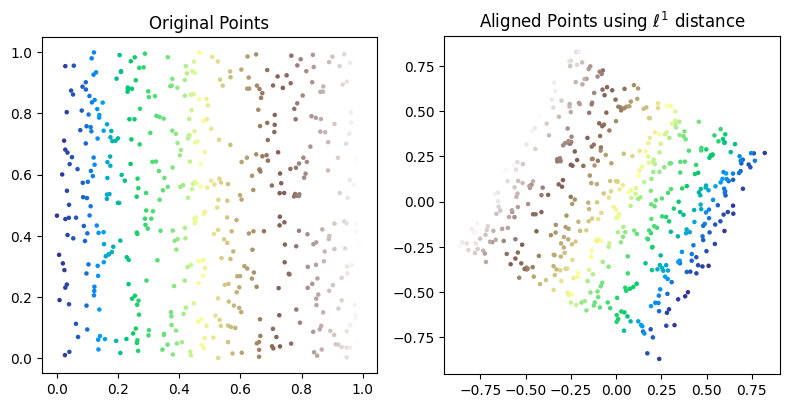

In [9]:
# noisy l1 (Manhattan) distances
# Other possibilities : ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, 
# ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, 
# ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’
d_manhattan = pdist(x, metric='cityblock')
alpha = 0.5  # noise level
noise = np.random.uniform(1-alpha, 1+alpha, size=len(d_manhattan))
d_manhattan = d_manhattan * noise
d_manhattan_square = squareform(d_manhattan)

mds = MDS(dissimilarity='precomputed',normalized_stress=False)
y_man = mds.fit_transform(d_manhattan_square)

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first set of points on the first subplot
axes[0].scatter(x[:, 0], x[:, 1], c=c, s=5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title("Original Points")

# Plot the second set of points on the second subplot
axes[1].scatter(y_man[:, 0], y_man[:, 1], c=c, s=5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title("Aligned Points using $\ell^1$ distance")

# Display the plots side by side
plt.tight_layout()
plt.show()

# The output is suspiciously faithful because sklearn.manifold.MDS actually uses a refined 
# algorithm called SMACOF : https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.smacof.html

Now use your handmade version.

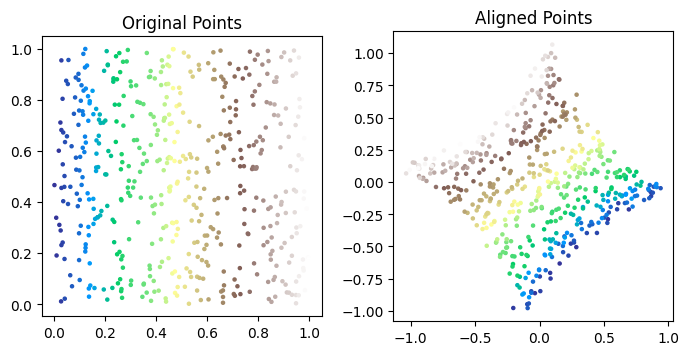

In [10]:
# noisy l1 (Manhattan) distances
d_manhattan = pdist(x, metric='cityblock')
alpha = 0.5  # noise level
noise = np.random.uniform(1-alpha, 1+alpha, size=len(d_manhattan))
d_manhattan = d_manhattan * noise
d_manhattan_square = squareform(d_manhattan)

y_man, evals_man = MDS_DIY(d_manhattan_square,dim=2)

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Plot the first set of points on the first subplot
axes[0].scatter(x[:, 0], x[:, 1], c=c, s=5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title("Original Points")

# Plot the second set of points on the second subplot
axes[1].scatter(y_man[:, 0], y_man[:, 1], c=c, s=5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title("Aligned Points")

# Display the plots side by side
plt.tight_layout()
plt.show()

What do you notice when comparing your version and the native one from **sklearn**?

## Testing on 3D toy data
Apply Classical MDS on the following three-dimensional synthetic dataset called "Swiss roll"

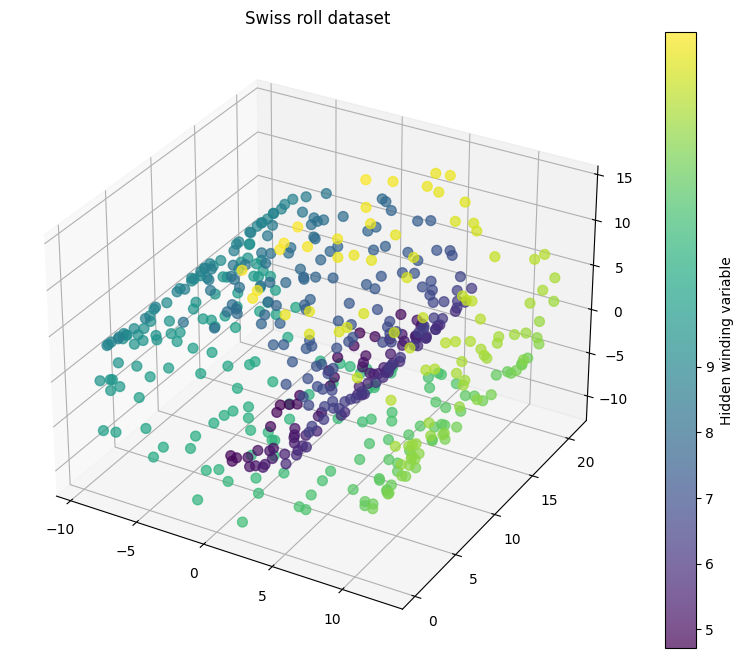

In [53]:
# Dataset
x_roll, c = datasets.make_swiss_roll(n_samples=500)

# Apply MDS to reduce dimensions to 3D
pick = random.sample(range(0,x_roll.shape[1],1),3)
x = X_digits[:,pick]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D, color by digit class
scatter = ax.scatter(x_roll[:, 0], x_roll[:, 1], x_roll[:, 2], c=c, s=50, alpha=0.7)

# Add color bar (legend for digit classes)
cb = fig.colorbar(scatter, ax=ax, ticks=range(10))
cb.set_label('Hidden winding variable')

# Add labels and title
ax.set_title('Swiss roll dataset')

# Show plot
plt.show()

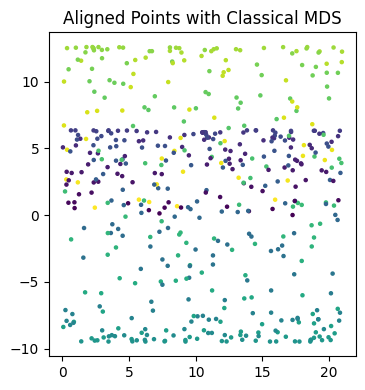

In [69]:
#Here is the dataset loaded with a random vizualisation of it.

pick = random.sample(range(0,x_roll.shape[1],1),2)
y = x_roll[:,pick]

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 4))

# Plot the MDS points
axes.scatter(y[:, 0], y[:, 1], c=c, s=5)
axes.set_aspect('equal', adjustable='box')
axes.set_title("Aligned Points with Classical MDS")

# Display the plots side by side
plt.tight_layout()
plt.show()

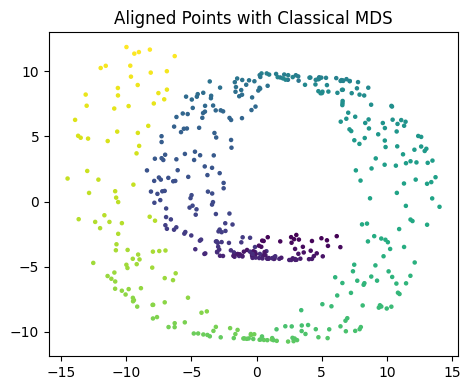

In [70]:
# Dataset
# l2 (Euclidean) distances
d = pdist(x_roll, metric='euclidean')
d_square = squareform(d)

y,evals = MDS_DIY(d_square,dim=2)

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 4))

# Plot the MDS points
axes.scatter(y[:, 0], y[:, 1], c=c, s=5)
axes.set_aspect('equal', adjustable='box')
axes.set_title("Aligned Points with Classical MDS")

# Display the plots side by side
plt.tight_layout()
plt.show()

## Iris dataset
Apply Classical MDS and its landmark version to the famous Iris dataset from UCI.

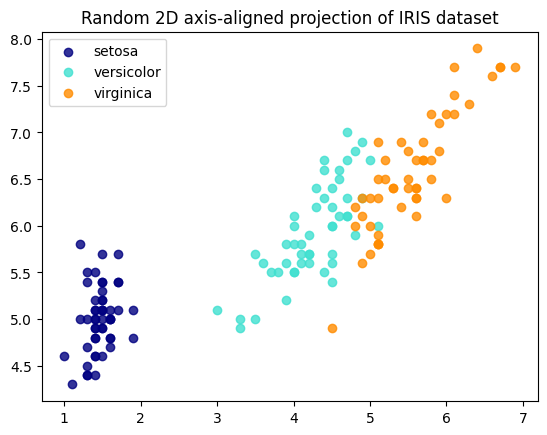

In [11]:
#Here is the dataset loaded with a random vizualisation of it.
from scipy.spatial import distance
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data
y_iris = iris.target
target_names_iris = iris.target_names

pick = random.sample(range(0,X_iris.shape[1],1),2)
x = X_iris[:,pick]

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']

for color, i, target_name in zip(colors, [0, 1, 2], target_names_iris):
    plt.scatter(x[y_iris == i, 0], x[y_iris == i, 1], alpha=.8, color=color,label=target_names_iris[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Random 2D axis-aligned projection of IRIS dataset')
plt.show()

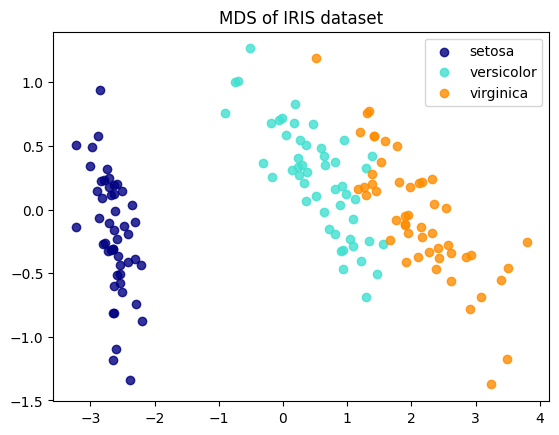

In [12]:
D_iris = distance.cdist(X_iris, X_iris, 'euclidean')
x2, evals = MDS_DIY(D_iris,dim=2)
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']

for color, i, target_name in zip(colors, [0, 1, 2], target_names_iris):
    plt.scatter(x2[y_iris == i, 0], x2[y_iris == i, 1], alpha=.8, color=color,label=target_names_iris[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('MDS of IRIS dataset')
plt.show()

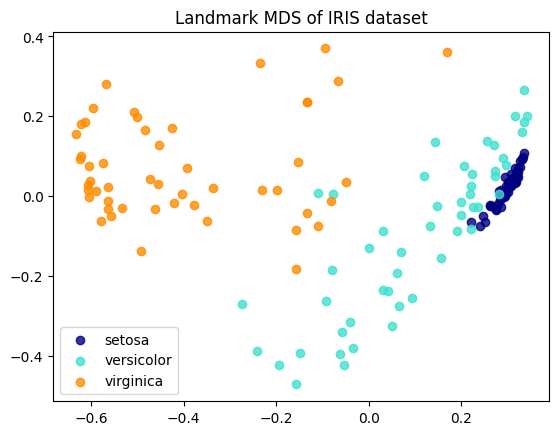

In [13]:
lands = random.sample(range(0,X_iris.shape[0],1),10)
lands = np.array(lands,dtype=int)
Dl2 = distance.cdist(X_iris[lands,:], X_iris, 'euclidean')

xl_2,evalsl_2 = landmark_MDS_DIY(Dl2,lands,2)

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names_iris):
    plt.scatter(xl_2[y_iris == i, 0], xl_2[y_iris == i, 1], alpha=.8, color=color,label=target_names_iris[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Landmark MDS of IRIS dataset')
plt.show()

## Digits dataset
### Time comparison
On the **digits** dataset, compare the runtimes of classical MDS and its landmark version.

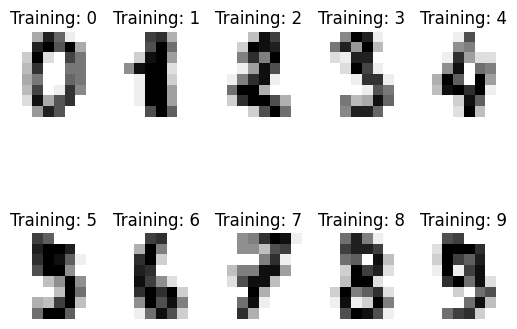

In [14]:
#Load and returns the digits dataset (classification) 
# Each datapoint is a 8x8 image of a digit
from sklearn.datasets import load_digits
digits = load_digits() 
Xd = digits.data
labels = digits.target
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [15]:
%%time
D = distance.cdist(Xd, Xd, 'euclidean')
x2 = MDS_DIY(D,dim=2)

CPU times: user 2.48 s, sys: 1.56 s, total: 4.04 s
Wall time: 667 ms


In [16]:
import random
lands = random.sample(range(0,Xd.shape[0],1),10)
lands = np.array(lands,dtype=int)

In [17]:
%%time
Dl2 = distance.cdist(Xd[lands,:], Xd, 'euclidean')
xl_2 = landmark_MDS_DIY(Dl2,lands,dim=2)

CPU times: user 4.15 ms, sys: 5.04 ms, total: 9.19 ms
Wall time: 1.4 ms


### Vizualisation

Vizualise the **Digits** dataset with classes using MDS. Try dimension 2 and 3.

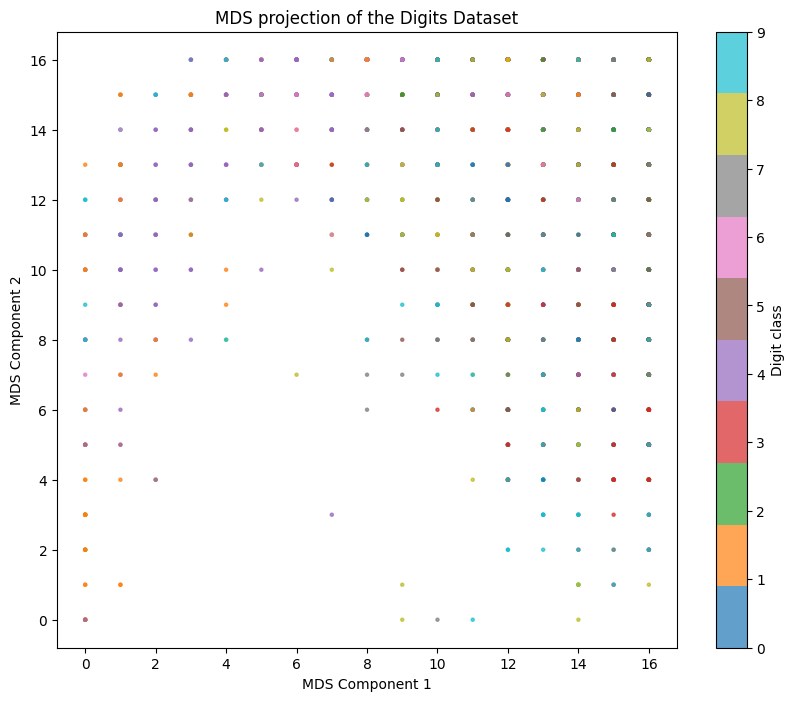

In [18]:
#Here is the dataset loaded with a random vizualisation of it.

# Extract features (X) and labels (y)
X_digits = digits.data
y_digits = digits.target

# Randomly pick two axes and projecting onto them
pick = random.sample(range(0,X_digits.shape[1],1),2)
x = X_digits[:,pick]

# Create a scatter plot of the MDS result
plt.figure(figsize=(10, 8))

# Create a color map based on the labels (digits 0-9)
scatter = plt.scatter(x[:, 0], x[:, 1], c=y_digits, cmap='tab10', s=5, alpha=0.7)

# Add color bar (legend for digit classes)
plt.colorbar(scatter, ticks=range(10), label='Digit class')

# Add labels and title
plt.title('MDS projection of the Digits Dataset')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')

# Show plot
plt.show()


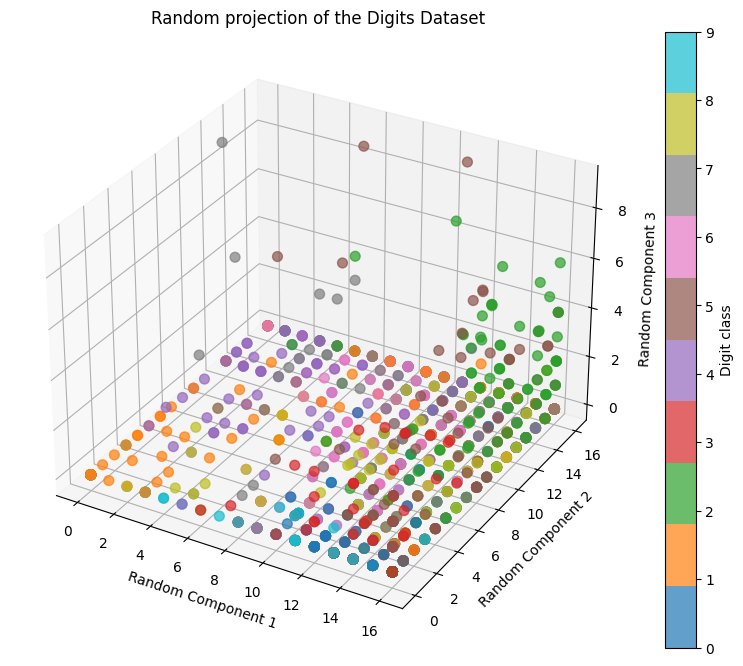

In [19]:
# Apply MDS to reduce dimensions to 3D
pick = random.sample(range(0,X_digits.shape[1],1),3)
x = X_digits[:,pick]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D, color by digit class
scatter = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_digits, cmap='tab10', s=50, alpha=0.7)

# Add color bar (legend for digit classes)
cb = fig.colorbar(scatter, ax=ax, ticks=range(10))
cb.set_label('Digit class')

# Add labels and title
ax.set_title('Random projection of the Digits Dataset')
ax.set_xlabel('Random Component 1')
ax.set_ylabel('Random Component 2')
ax.set_zlabel('Random Component 3')

# Show plot
plt.show()

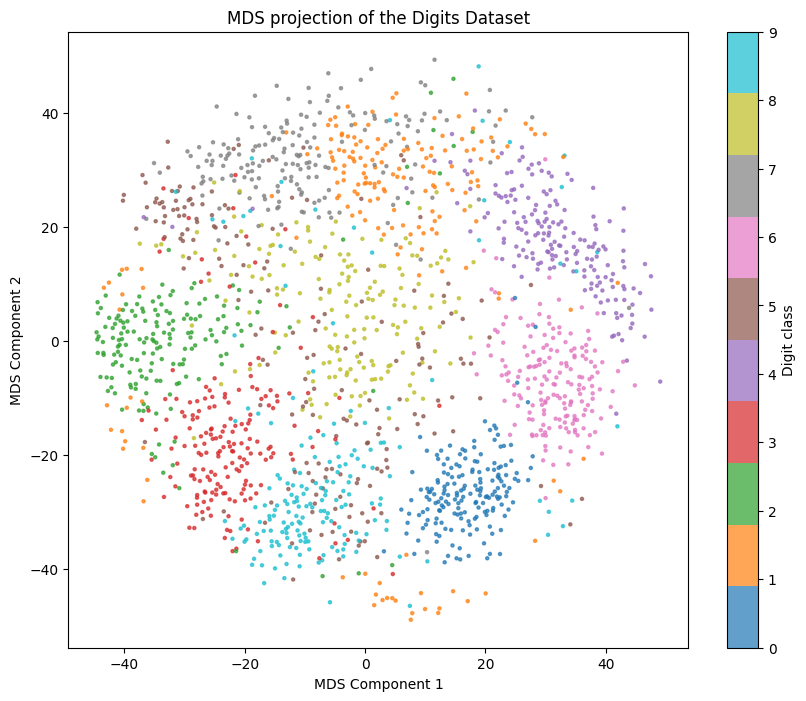

In [20]:
# Extract features (X) and labels (y)
X_digits = digits.data
y_digits = digits.target

# Apply MDS to reduce dimensions to 2D
mds = MDS(n_components=2,normalized_stress = False)
X_mds = mds.fit_transform(X_digits)

# Create a scatter plot of the MDS result
plt.figure(figsize=(10, 8))

# Create a color map based on the labels (digits 0-9)
scatter = plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_digits, cmap='tab10', s=5, alpha=0.7)

# Add color bar (legend for digit classes)
plt.colorbar(scatter, ticks=range(10), label='Digit class')

# Add labels and title
plt.title('MDS projection of the Digits Dataset')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')

# Show plot
plt.show()


### Using sklearn 3D

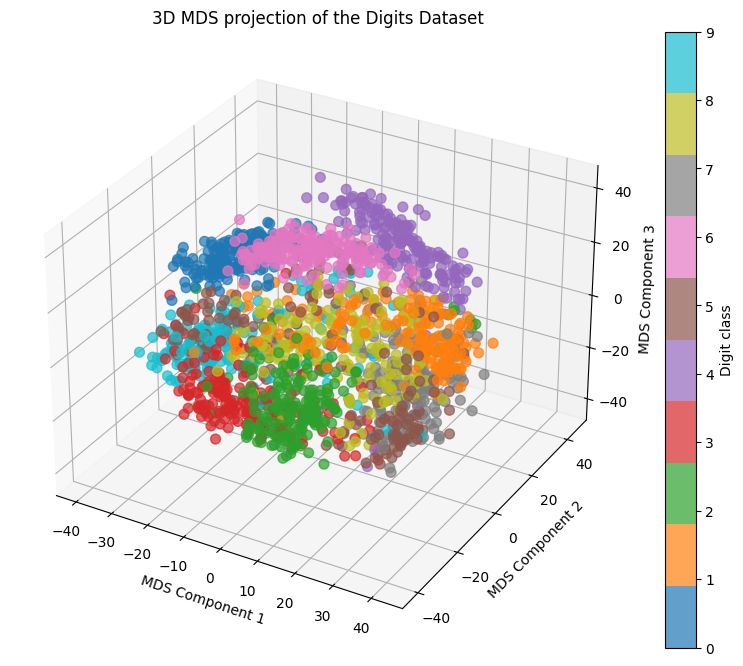

In [21]:
# Apply MDS to reduce dimensions to 3D
mds = MDS(n_components=3,normalized_stress = False)
X_mds = mds.fit_transform(X_digits)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D, color by digit class
scatter = ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:, 2], c=y_digits, cmap='tab10', s=50, alpha=0.7)

# Add color bar (legend for digit classes)
cb = fig.colorbar(scatter, ax=ax, ticks=range(10))
cb.set_label('Digit class')

# Add labels and title
ax.set_title('3D MDS projection of the Digits Dataset')
ax.set_xlabel('MDS Component 1')
ax.set_ylabel('MDS Component 2')
ax.set_zlabel('MDS Component 3')

# Show plot
plt.show()

### Using homemade CS

#### Projecting in 2D

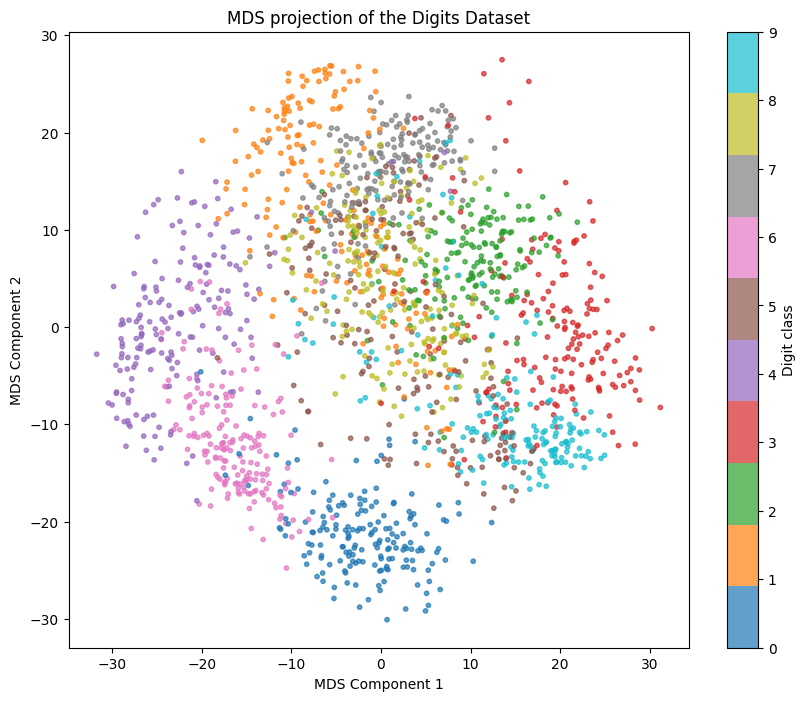

In [22]:
D_digit = pairwise_distances(X_digits)
X_mds,evals = MDS_DIY(D_digit,dim=2) 

# Create a scatter plot of the MDS result
plt.figure(figsize=(10, 8))

# Create a color map based on the labels (digits 0-9)
scatter = plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y_digits, cmap='tab10', s=10, alpha=.7)

# Add color bar (legend for digit classes)
plt.colorbar(scatter, ticks=range(10), label='Digit class')

# Add labels and title
plt.title('MDS projection of the Digits Dataset')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')

# Show plot
plt.show()

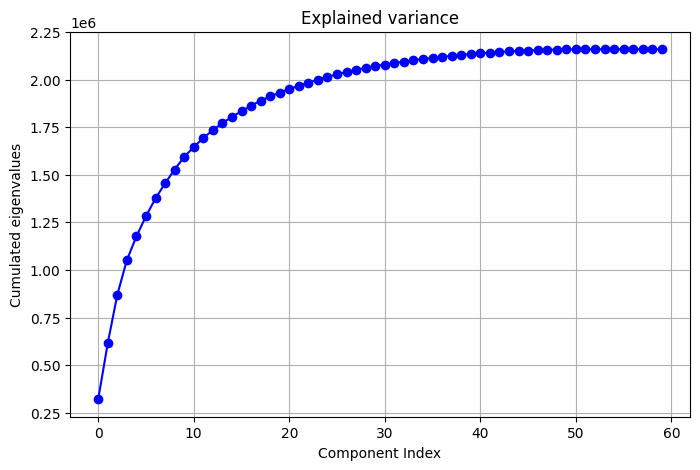

In [23]:
plot_eigenvalue_decay(evals[:60])

#### Projecting in 3D

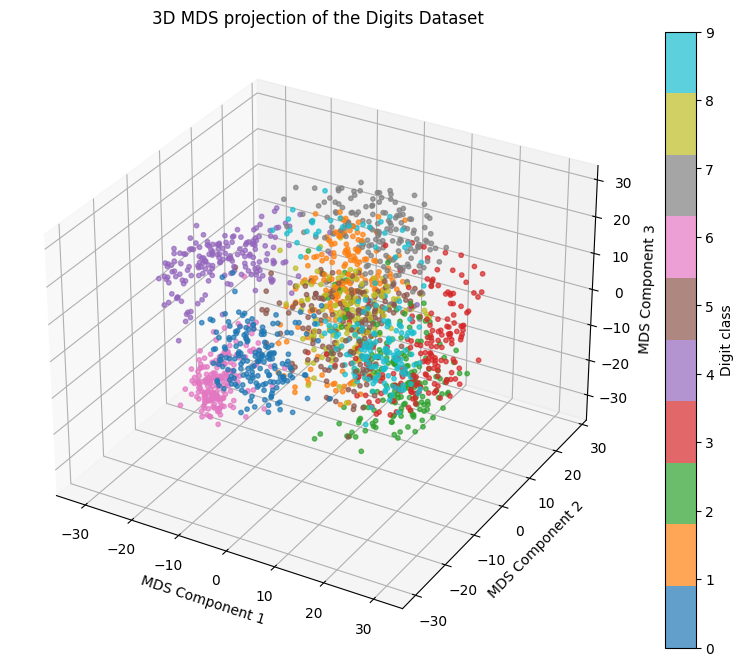

In [24]:
D_digit = pairwise_distances(X_digits)
X_mds,evals = MDS_DIY(D_digit,dim=3)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D, color by digit class
scatter = ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:, 2], c=y_digits, cmap='tab10', s=10, alpha=0.7)

# Add color bar (legend for digit classes)
cb = fig.colorbar(scatter, ax=ax, ticks=range(10))
cb.set_label('Digit class')

# Add labels and title
ax.set_title('3D MDS projection of the Digits Dataset')
ax.set_xlabel('MDS Component 1')
ax.set_ylabel('MDS Component 2')
ax.set_zlabel('MDS Component 3')

# Show plot
plt.show()